In [ ]:
pip install --upgrade tensorflow

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout
from keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework import tensor_shape

from keras import backend as K


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def relu6(x):
    """Relu 6
    """
    return K.relu(x, max_value=6.0)


def _conv_block(inputs, filters, kernel, strides):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    input_shape = inputs.shape
    input_shape = tensor_shape.TensorShape(input_shape)
    in_channels = int(input_shape[channel_axis])
    #x = GroupConv2D(filters, (kernel, kernel), groups = 1, padding = 'same', strides = strides)(inputs)
    x = dynamic_conv2d(in_channels = in_channels, out_channels = filters, kernel_size = kernel, ratio = 0.25, padding = 'SAME', strides = strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    return Activation(relu6)(x)


def _bottleneck(inputs, filters, kernel, t, alpha, s, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        alpha: Integer, width multiplier.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = K.int_shape(inputs)[channel_axis] * t
    # Width
    cchannel = int(filters * alpha)

    x = _conv_block(inputs, tchannel, 1, 1)
    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)
    input_shape = x.shape
    input_shape = tensor_shape.TensorShape(input_shape)
    in_channels = int(input_shape[channel_axis])
    #x = GroupConv2D(cchannel, (1, 1), groups = 1, padding = 'same')(x)
    x = dynamic_conv2d(in_channels = in_channels, out_channels = cchannel, kernel_size = 1, ratio = 0.25, padding = 'SAME', strides = 1)(x)
    x = BatchNormalization(axis=channel_axis)(x)

    if r:
        x = Add()([x, inputs])

    return x


def _inverted_residual_block(inputs, filters, kernel, t, alpha, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        alpha: Integer, width multiplier.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs, filters, kernel, t, alpha, strides)

    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, alpha, 1, True)

    return x


def MobileNetv2(input_shape, batch_size, k, alpha=1.0):
    """MobileNetv2
    This function defines a MobileNetv2 architectures.
    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor.
        k: Integer, number of classes.
        alpha: Integer, width multiplier, better in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4].
    # Returns
        MobileNetv2 model."""
        
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    inputs = Input(shape=input_shape, batch_size = batch_size)

    first_filters = _make_divisible(32 * alpha, 8)
    x = _conv_block(inputs, first_filters, 3, strides = 2)

    x = _inverted_residual_block(x, 16, (3, 3), t=1, alpha=alpha, strides=1, n=1)
    x = _inverted_residual_block(x, 24, (3, 3), t=6, alpha=alpha, strides=2, n=2)
    x = _inverted_residual_block(x, 32, (3, 3), t=6, alpha=alpha, strides=2, n=3)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, alpha=alpha, strides=2, n=4)
    x = _inverted_residual_block(x, 96, (3, 3), t=6, alpha=alpha, strides=1, n=3)
    x = _inverted_residual_block(x, 160, (3, 3), t=6, alpha=alpha, strides=2, n=3)
    x = _inverted_residual_block(x, 320, (3, 3), t=6, alpha=alpha, strides=1, n=1)

    if alpha > 1.0:
        last_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_filters = 1280

    x = _conv_block(x, last_filters, 1, strides = 1)
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, last_filters))(x)
    x = Dropout(0.3, name='Dropout')(x)
    input_shape = x.shape
    input_shape = tensor_shape.TensorShape(input_shape)
    in_channels = int(input_shape[channel_axis])
    x = dynamic_conv2d(in_channels = in_channels, out_channels = k, kernel_size = 1, ratio = 0.25, padding = 'SAME')(x)
    #x = GroupConv2D(k, (1, 1), groups = 1, padding = 'same')(x)
    x = Activation('softmax', name='softmax')(x)
    output = Reshape((k,))(x)

    model = Model(inputs, output)
    # plot_model(model, to_file='images/MobileNetv2.png', show_shapes=True)

    return model

In [13]:
model = MobileNetv2((180, 180, 3), 32, 5, 1.0)
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 180, 180, 3)]  0                                            
__________________________________________________________________________________________________
dynamic_conv2d (dynamic_conv2d) (32, 90, 90, 32)     3620        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (32, 90, 90, 32)     128         dynamic_conv2d[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (32, 90, 90, 32)     0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
with tf.GradientTape() as tape:
        out = model(tf.random.normal(shape=(1, 224, 224, 3)))
        summed = tf.reduce_sum(out)
        grad = tape.gradient(summed, model.variables)



In [2]:
import tensorflow as tf
from keras.engine import Layer
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
import tensorflow as tf
import math
import numpy as np
import glob
import torch
import random
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv3D, GlobalAveragePooling3D, Dropout, BatchNormalization, Conv2D, LeakyReLU, Input, MaxPool2D, AveragePooling2D, ELU, UpSampling2D, ReLU, Softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.utils import conv_utils
import tensorflow.keras.activations as activations
import tensorflow.keras.regularizers as regularizers
import tensorflow.keras.initializers as initializers
import tensorflow.keras.constraints as constraints
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import nn


class GroupConvBase(tf.keras.layers.Layer):

    def __init__(self, rank, filters, kernel_size, groups=1, strides=1, padding='VALID', data_format=None,
                 dilation_rate=1,
                 activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                 bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None, weight=None, bias=None, **kwargs):
        super().__init__(activity_regularizer=activity_regularizer, **kwargs)
        if filters % groups != 0:
            raise ValueError("Groups must divide filters evenly, but got {}/{}".format(filters, groups))

        self.filters = filters
        self.groups = groups
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.data_format = data_format
        self.padding = padding
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.weight = weight
        self.bias = bias

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        if conv_utils.normalize_data_format(self.data_format) == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape.dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = int(input_shape[channel_axis])
        kernel_shape = self.kernel_size + (input_dim // self.groups, self.filters)
        if self.weight != None:
          self.kernel = self.weight
        else:
          self.kernel = self.add_weight(
              name='kernel',
              shape=kernel_shape,
              initializer=self.kernel_initializer,
              regularizer=self.kernel_regularizer,
              constraint=self.kernel_constraint,
              trainable=True,
              dtype=self.dtype)
        if self.use_bias:
          if self.bias != None:
            self.bias = self.bias
          else:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.filters,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                trainable=True,
                dtype=self.dtype)
        else:
            self.bias = None

        self.built = True

    def call(self, inputs):
        outputs = tf.nn.conv2d(inputs, self.kernel, strides=self.strides,
                                       data_format=self.data_format, dilations=self.dilation_rate,
                                       name=self.name,
                                       padding=self.padding)

        if self.use_bias:
            if self.data_format == 'channels_first':
                if self.rank == 1:
                    # nn.bias_add does not accept a 1D input tensor.
                    bias = array_ops.reshape(self.bias, (1, self.filters, 1))
                    outputs += bias
                else:
                    outputs = nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = nn.bias_add(outputs, self.bias, data_format='NHWC')

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def get_config(self):
        config = {
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            "groups": self.groups,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer':
                regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint),
            'weight': self.weight,
            'bias': self.bias
        }
        return {list(super(GroupConvBase, self).get_config().items()) + list(config.items())}

class GroupConv2D(GroupConvBase):
  def __init__(self, filters,kernel_size,groups, strides=(1, 1),padding='valid',data_format=None,dilation_rate=(1, 1),activation=None,use_bias=True,kernel_initializer='glorot_uniform',bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,bias_constraint=None, weight = None, bias = None, **kwargs):
    super(GroupConv2D, self).__init__(rank = 2, filters = filters, kernel_size = kernel_size, groups = groups, strides = strides, padding = padding.upper(), data_format = data_format, dilation_rate = dilation_rate, activation = activations.get(activation), use_bias = use_bias, kernel_initializer = initializers.get(kernel_initializer), bias_initializer = initializers.get(bias_initializer), kernel_regularizer = regularizers.get(kernel_regularizer), bias_regularizer = regularizers.get(bias_regularizer), activity_regularizer = regularizers.get(activity_regularizer), kernel_constraint = constraints.get(kernel_constraint), bias_constraint = constraints.get(bias_constraint), weight = weight, bias = bias, **kwargs)

In [4]:
class attention2d(tf.keras.layers.Layer):
  def __init__(self, in_channels, ratio, K, temp):
    super(attention2d, self).__init__()

    assert temp % 3 == 1

    self.avgpool = GlobalAveragePooling2D()

    if in_channels != 3:
      hidden_channels = int(in_channels * ratio)
    else:
      hidden_channels = K

    self.fc1 = Conv2D(hidden_channels, kernel_size = 1)
    self.fc2 = Conv2D(K, kernel_size = 1)
    self.temp = temp

  def update_temp(self):
    if self.temp != 1:
      self.temp -= 3

  def __call__(self, x):
    x = self.avgpool(x)
    x = tf.reshape(x, [tf.shape(x)[0], 1, 1, tf.shape(x)[-1]]) 
    x = self.fc1(x)
    x = tf.nn.relu(x)
    x = self.fc2(x)
    x = tf.reshape(x, [tf.shape(x)[0], -1])
    return tf.nn.softmax(x / self.temp, 1)

In [5]:
class dynamic_conv2d(tf.keras.layers.Layer):
  
  def __init__(self, in_channels, out_channels, kernel_size, ratio = 0.25, strides = 1, padding = 'VALID', K = 4, temp = 34, groups = 1, dilation = 1, use_bias = True):
    super(dynamic_conv2d, self).__init__()
    
    assert in_channels % groups == 0

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.strides = strides
    self.padding = padding
    self.dilation = dilation
    self.groups = groups
    self.use_bias = use_bias
    self.K = K
    self.att = attention2d(in_channels, ratio, K, temp)

    init1 = tf.initializers.GlorotUniform()
    init2 = tf.initializers.Zeros()
    self.w = tf.Variable(init1(shape = (K, kernel_size, kernel_size, in_channels, out_channels)), trainable = True)
    if use_bias:
      self.b = tf.Variable(init2(shape = (K, out_channels)), trainable = True)
    else:
      self.b = None
    
  def update_temp(self):
    self.att.update_temp()

  def call(self, x):
    softmax_att = self.att(x)
    softmax_att = self.att(x)
    batch_size, height, width, in_channels = x.shape
    x = tf.transpose(x, [1, 2, 0, 3])
    x = tf.reshape(x, [1, height, width, batch_size * in_channels])
    weight = tf.reshape(self.w, [self.K, -1])
    agg_w = tf.reshape(tf.matmul(softmax_att, weight), [batch_size, self.kernel_size, self.kernel_size, self.in_channels, self.out_channels])
    agg_w = tf.transpose(agg_w, [1, 2, 0, 3, 4])
    agg_w = tf.reshape(agg_w, [self.kernel_size, self.kernel_size, self.in_channels * batch_size, self.out_channels])
    out = tf.nn.depthwise_conv2d(x, agg_w, strides = [1, 1, 1, 1], padding = 'SAME')
    out = tf.reshape(out, [height, width, batch_size, self.in_channels, self.out_channels])
    out = tf.transpose(out, [2, 0, 1, 3, 4])
    out = tf.reduce_sum(out, axis = 3)
    out = tf.nn.max_pool(out, (1, 1), strides = self.strides, padding = 'VALID')
    return out 

In [6]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 1s 0us/step


In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.198,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2944 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2008,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 736 files for validation.


In [10]:
from tensorflow.keras import layers
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model1 = tf.keras.applications.MobileNetV2()

In [ ]:
model1.summary()

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 277s 3s/step - loss: 1.1325 - accuracy: 0.7683 - val_loss: 1.1998 - val_accuracy: 0.7011
Epoch 2/10
10/92 [==>...........................] - ETA: 3:28 - loss: 1.1472 - accuracy: 0.7594

KeyboardInterrupt: 

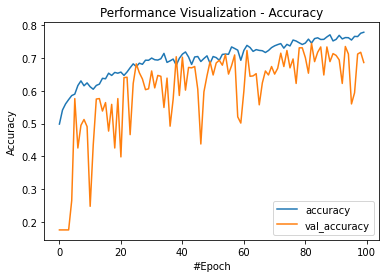

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('#Epoch')
plt.ylabel('Accuracy')
plt.title('Performance Visualization - Accuracy')
plt.show()

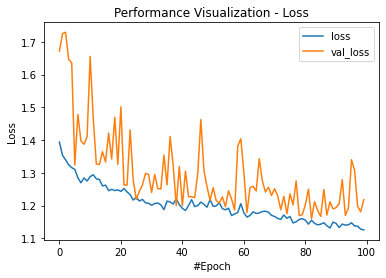

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.title('Performance Visualization - Loss')
plt.show()
